In [ ]:
import nltk
import pandas as pd
import plotly.express as px
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий.


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.hidden_size = hidden_size
        self.input_size = input_size

    def forward(self, x, h=None):
        batch_size, seq_size, emb_size = x.shape
        # инициализация тензора скрытых состояний
        if h is None:
            h = torch.zeros(batch_size, self.hidden_size).to(device=x.device)
        # проход по каждому элементу последовательностей s в батче и обновление скрытого состояния
        out = torch.zeros(batch_size, seq_size, self.hidden_size)
        for t in range(seq_size):
            h = self.rnn_cell(x[:, t, :], h)
            out[:, t] = h

        # вернуть тензор всех наблюдавшихся скрытых состояний размера (batch_size, seq_len, hidden_size) и тензор скрытых состояний в последний момент времени
        return out, h

In [ ]:
batch_size, seq_len, embedding_size, hidden_size = 5, 5, 7, 10
test = torch.rand(batch_size, seq_len, embedding_size)
rnn = RNN(embedding_size, hidden_size)
with torch.no_grad():
    t = rnn(test)
    print(t[0].shape, t[0][:1, :3, :3], t[1].shape, sep='\n')

torch.Size([5, 5, 10])
tensor([[[0.1581, 0.3920, 0.8430],
         [0.1199, 0.5280, 0.8340],
         [0.1026, 0.4763, 0.8084]]])
torch.Size([5, 10])


In [ ]:
train_surnames = pd.read_csv('surnames.csv')
class_encoder = LabelEncoder()
train_surnames['nationality'] = class_encoder.fit_transform(train_surnames['nationality'])

surname = train_surnames['surname'].str.lower()
nat = train_surnames['nationality']
n_classes = nat.nunique()

x_train, x_test, y_train, y_test = train_test_split(surname, nat, test_size=0.2, random_state=1)

In [ ]:
print(n_classes)

18


In [ ]:
class Vocab:
    def __init__(self, data):
        tokens = set()
        self.max_seq_len = 0
        for item in data:
            tokens.update(item)
            self.max_seq_len = max(self.max_seq_len, len(item))
        self.unk_token = '<UNK>'
        self.pad_token = '<PAD>'
        self.idx_to_token = dict(enumerate(tokens, 2))
        self.idx_to_token[1] = self.unk_token
        self.idx_to_token[0] = self.pad_token
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)


class SurnamesDataset(Dataset):
    def __init__(self, surname, nat, vocab):
        self.surname = surname
        self.nat = nat
        self.vocab = vocab

    def to_sequence(self, surname):
        tok_seq = [self.vocab.token_to_idx[tok] for tok in surname]
        padds_len = self.vocab.max_seq_len - len(tok_seq)
        pad_idx = self.vocab.token_to_idx[self.vocab.pad_token]
        padds = [pad_idx] * padds_len
        return torch.LongTensor(tok_seq + padds)

    def __len__(self):
        return len(self.surname)

    def __getitem__(self, idx):
        return self.to_sequence(self.surname.iloc[idx]), self.nat.iloc[idx]


In [ ]:
vocab = Vocab(surname)
train_dataset = SurnamesDataset(x_train, y_train, vocab)
test_dataset = SurnamesDataset(x_test, y_test, vocab)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
class RNNClassifierCustomRNN(nn.Module):
    def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
        self.rnn = RNN(embedding_size, rnn_hidden_size)
        self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size, rnn_hidden_size),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(rnn_hidden_size, num_classes))
        self.dropout = nn.Dropout(0.5)

    def forward(self, surname):
        out = self.embedding(surname)  # batch x seq x emb
        out = self.rnn(out)[1]  # batch x rnn_hidden
        out = self.dropout(out)  # batch x rnn_hidden
        out = self.classifier(out)  # batch x num_classes
        return out


In [ ]:
model = RNNClassifierCustomRNN(
    vocab_len=vocab.vocab_len,
    embedding_size=128,
    rnn_hidden_size=64,
    num_classes=n_classes
)


def train(_model: torch.nn.Module, path: str = 'surname_model.pt'):
    optimizer = torch.optim.Adam(_model.parameters(), weight_decay=0.001)
    loss = torch.nn.CrossEntropyLoss()
    loss_log = []
    loss_log_val = []
    min_val_loss = 10 ** 10

    for i in range(20):
        epoch_loss = 0
        epoch_loss_val = 0

        j, k = 1, 1  # Делители running losses

        _model.train()
        for j, (batch_x, batch_y) in enumerate(train_loader):
            y_pred = _model(batch_x)
            running_loss = loss(y_pred, batch_y)
            epoch_loss += running_loss.item()

            running_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        _model.eval()
        for k, (batch_x, batch_y) in enumerate(test_loader):
            y_pred = _model(batch_x)
            running_loss = loss(y_pred, batch_y)
            epoch_loss_val += running_loss.item()

        epoch_loss /= j
        epoch_loss_val /= k

        if epoch_loss_val < min_val_loss:
            torch.save(_model.state_dict(), path)

        if i % 2 == 0:
            print(f'EPOCH: {i + 1:3d} \t LOSS: {epoch_loss:0.4f} \t VAL LOSS: {epoch_loss_val:0.4f}')

        loss_log.append(epoch_loss)
        loss_log_val.append(epoch_loss_val)

    _model.load_state_dict(torch.load(path))
    return _model, loss_log, loss_log_val


model, loss_log, loss_log_val = train(model)

EPOCH:   1 	 LOSS: 2.4928 	 VAL LOSS: 2.3599
EPOCH:   3 	 LOSS: 2.1803 	 VAL LOSS: 2.0894
EPOCH:   5 	 LOSS: 1.9362 	 VAL LOSS: 1.9314
EPOCH:   7 	 LOSS: 1.7594 	 VAL LOSS: 1.7233
EPOCH:   9 	 LOSS: 1.6454 	 VAL LOSS: 1.6239
EPOCH:  11 	 LOSS: 1.5872 	 VAL LOSS: 1.5569
EPOCH:  13 	 LOSS: 1.5031 	 VAL LOSS: 1.5121
EPOCH:  15 	 LOSS: 1.4651 	 VAL LOSS: 1.5040
EPOCH:  17 	 LOSS: 1.4268 	 VAL LOSS: 1.4481
EPOCH:  19 	 LOSS: 1.4027 	 VAL LOSS: 1.4936


<Axes: >

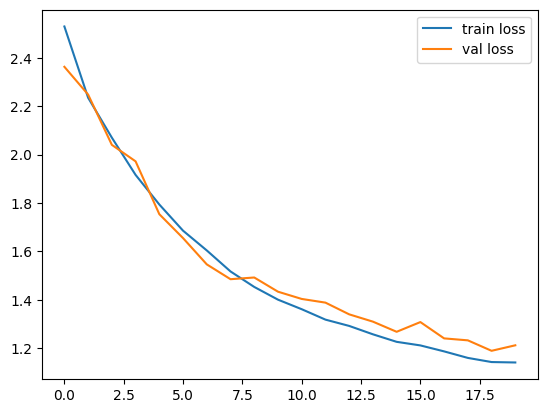

In [ ]:
pd.DataFrame({'train loss': loss_log_lstm, 'val loss': loss_log_val_lstm}).plot()

In [ ]:
right_answers = 0
for batch_x, batch_y in DataLoader(test_dataset, batch_size=32):
    predictions = model(batch_x).argmax(dim=1)
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TEST ACCURACY: {right_answers / len(test_dataset):0.4f}')

TEST ACCURACY: 0.6321


|1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

EPOCH:   1 	 LOSS: 2.5115 	 VAL LOSS: 2.3765
EPOCH:   3 	 LOSS: 2.1941 	 VAL LOSS: 2.0967
EPOCH:   5 	 LOSS: 1.8676 	 VAL LOSS: 1.8536
EPOCH:   7 	 LOSS: 1.6943 	 VAL LOSS: 1.6879
EPOCH:   9 	 LOSS: 1.5864 	 VAL LOSS: 1.6562
EPOCH:  11 	 LOSS: 1.5222 	 VAL LOSS: 1.5016
EPOCH:  13 	 LOSS: 1.4885 	 VAL LOSS: 1.4957
EPOCH:  15 	 LOSS: 1.4218 	 VAL LOSS: 1.4386
EPOCH:  17 	 LOSS: 1.3719 	 VAL LOSS: 1.4013
EPOCH:  19 	 LOSS: 1.3561 	 VAL LOSS: 1.3827
TEST ACCURACY: 0.6562


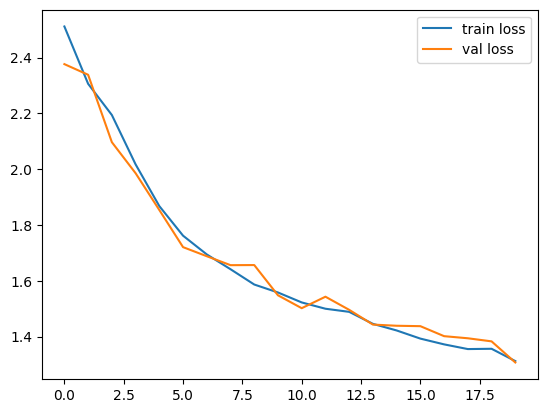

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
        self.rnn = torch.nn.RNN(embedding_size, rnn_hidden_size, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size, rnn_hidden_size),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(rnn_hidden_size, num_classes))
        self.dropout = nn.Dropout(0.5)

    def forward(self, surname):
        out = self.embedding(surname)  # batch x seq x emb

        out = self.rnn(out)[1].squeeze(0)  # batch x rnn_hidden

        out = self.dropout(out)  # batch x rnn_hidden
        out = self.classifier(out)  # batch x num_classes
        return out


model = RNNClassifier(
    vocab_len=vocab.vocab_len,
    embedding_size=128,
    rnn_hidden_size=64,
    num_classes=n_classes
)

model, loss_log_rnn, loss_log_val_rnn = train(model)
pd.DataFrame({'train loss': loss_log_rnn, 'val loss': loss_log_val_rnn}).plot()

right_answers = 0
for batch_x, batch_y in DataLoader(test_dataset, batch_size=32):
    predictions = model(batch_x).argmax(dim=1)
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TEST ACCURACY: {right_answers / len(test_dataset):0.4f}')

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
        self.lstm = torch.nn.LSTM(embedding_size, rnn_hidden_size, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size, rnn_hidden_size),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(rnn_hidden_size, num_classes))
        self.dropout = nn.Dropout(0.5)

    def forward(self, surname):
        out = self.embedding(surname)  # batch x seq x emb

        out = self.lstm(out)[1][0].squeeze(0)  # batch x rnn_hidden

        out = self.dropout(out)  # batch x rnn_hidden
        out = self.classifier(out)  # batch x num_classes
        return out


model = LSTMClassifier(
    vocab_len=vocab.vocab_len,
    embedding_size=128,
    rnn_hidden_size=64,
    num_classes=n_classes
)

model, loss_log_lstm, loss_log_val_lstm = train(model)

right_answers = 0
for batch_x, batch_y in DataLoader(test_dataset, batch_size=32):
    predictions = model(batch_x).argmax(dim=1)
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TEST ACCURACY: {right_answers / len(test_dataset):0.4f}')

EPOCH:   1 	 LOSS: 2.5346 	 VAL LOSS: 2.3625
EPOCH:   3 	 LOSS: 2.0884 	 VAL LOSS: 2.0605
EPOCH:   5 	 LOSS: 1.7963 	 VAL LOSS: 1.7728
EPOCH:   7 	 LOSS: 1.6150 	 VAL LOSS: 1.6263
EPOCH:   9 	 LOSS: 1.4805 	 VAL LOSS: 1.4322
EPOCH:  11 	 LOSS: 1.3862 	 VAL LOSS: 1.3459
EPOCH:  13 	 LOSS: 1.3260 	 VAL LOSS: 1.3654
EPOCH:  15 	 LOSS: 1.2500 	 VAL LOSS: 1.2825
EPOCH:  17 	 LOSS: 1.1952 	 VAL LOSS: 1.2185
EPOCH:  19 	 LOSS: 1.1858 	 VAL LOSS: 1.2143
TEST ACCURACY: 0.6853


<Axes: >

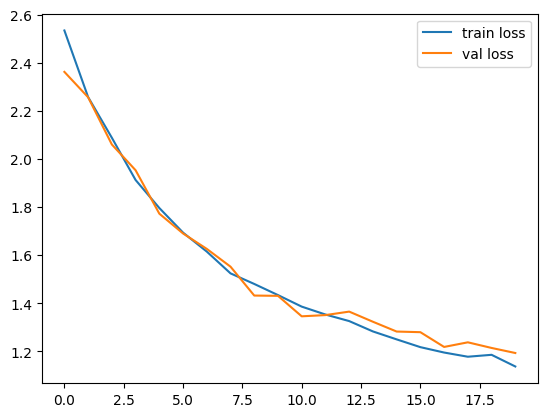

In [ ]:
pd.DataFrame({'train loss': loss_log_lstm, 'val loss': loss_log_val_lstm}).plot()

<Axes: >

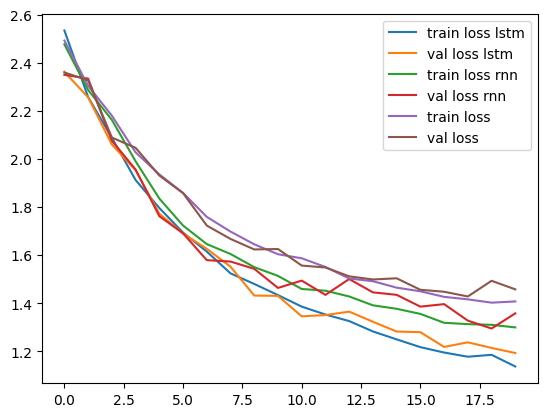

In [ ]:
pd.DataFrame(
        {
            'train loss lstm': loss_log_lstm,
            'val loss lstm': loss_log_val_lstm,
            'train loss rnn': loss_log_rnn,
            'val loss rnn': loss_log_val_rnn,
            'train loss': loss_log,
            'val loss': loss_log_val
        }
    ).plot()


1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

EPOCH:   1 	 LOSS: 2.5296 	 VAL LOSS: 2.3629
EPOCH:   3 	 LOSS: 2.0701 	 VAL LOSS: 2.0404
EPOCH:   5 	 LOSS: 1.7939 	 VAL LOSS: 1.7539
EPOCH:   7 	 LOSS: 1.6040 	 VAL LOSS: 1.5464
EPOCH:   9 	 LOSS: 1.4532 	 VAL LOSS: 1.4922
EPOCH:  11 	 LOSS: 1.3611 	 VAL LOSS: 1.4036
EPOCH:  13 	 LOSS: 1.2921 	 VAL LOSS: 1.3400
EPOCH:  15 	 LOSS: 1.2264 	 VAL LOSS: 1.2678
EPOCH:  17 	 LOSS: 1.1869 	 VAL LOSS: 1.2406
EPOCH:  19 	 LOSS: 1.1428 	 VAL LOSS: 1.1893
TEST ACCURACY: 0.6767


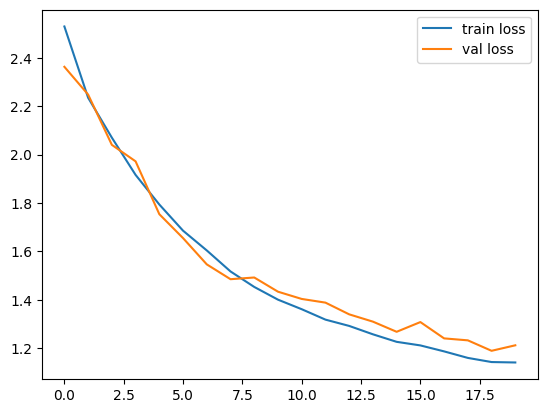

In [ ]:
with open('globe_100_rows.txt') as file:
    weights = file.readlines()
    weights = list(map(str.split, weights))
    weights = {i[0]: torch.tensor(list(map(float, i[1:]))) for i in weights}

model = LSTMClassifier(
    vocab_len=vocab.vocab_len,
    embedding_size=128,
    rnn_hidden_size=64,
    num_classes=n_classes
)

for token, value in weights.items():
    try:
        model.embedding.weight[vocab.token_to_idx[token]] = value
    except Exception:
        pass

model, loss_log_lstm, loss_log_val_lstm = train(model)
pd.DataFrame({'train loss': loss_log_lstm, 'val loss': loss_log_val_lstm}).plot()

right_answers = 0
for batch_x, batch_y in DataLoader(test_dataset, batch_size=32):
    predictions = model(batch_x).argmax(dim=1)
    right_answers += (torch.eq(batch_y, predictions)).sum()

print(f'TEST ACCURACY: {right_answers / len(test_dataset):0.4f}')

## 2. Классификация обзоров на фильмы (RNN)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`
    - подберите адекватную размерность вектора эмбеддинга:
    - модуль `nn.Embedding` обучается

  * Используйте рекуррентные слои (`nn.RNN`, `nn.LSTM`, `nn.GRU`)


2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [ ]:
# 2.0

with open('positive_reviews.txt') as file:
    pos_reviews = file.readlines()

pos_reviews = pd.DataFrame(pos_reviews, columns=['review'])
pos_reviews['positive'] = 1

with open('negative_reviews.txt') as file:
    neg_reviews = file.readlines()

neg_reviews = pd.DataFrame(neg_reviews, columns=['review'])
neg_reviews['positive'] = 0

reviews = pd.concat([pos_reviews, neg_reviews])

train_reviews, test_reviews = train_test_split(reviews, test_size=0.3)

reviews.sample(5, random_state=63)

,review,positive
3975,"beautiful , cold , oddly colorful and just pla...",0
4727,the film is delicately narrated by martin land...,0
2104,"an earnest , heartrending look at the divide b...",1
3255,suffers from a flat script and a low budget .\n,1
1243,the ch�teau would have been benefited from a s...,1


In [ ]:
!pip install wordnet

  Preparing metadata (setup.py) ... done
  Created wheel for wordnet: filename=wordnet-0.0.1b2-py3-none-any.whl size=10502 sha256=925972482d38be508f19900964c6d69176a42a821c26120f16114145628da957
  Stored in directory: /root/.cache/pip/wheels/c0/a1/e8/4649c8712033dcdbd1e64a0fc75216a5d1769665852c36b4f9
Successfully built wordnet


In [ ]:
# 2.1
from nltk import WordNetLemmatizer
from nltk import word_tokenize
from tqdm import tqdm
nltk.download('wordnet')

wnl = WordNetLemmatizer()


class Vocab:
    def __init__(self, data: pd.Series):
        _word_bag = {'<UNK>'}
        for sent in tqdm(data.review):
            sent = set(map(wnl.lemmatize, word_tokenize(sent)))
            _word_bag |= sent

        self.idx_to_token = dict(zip(range(1, len(_word_bag) + 1), _word_bag))

        self.token_to_idx = {v: u for u, v in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)
        self._word_bag = _word_bag


vocab_review = Vocab(train_reviews)

[nltk_data] Downloading package wordnet to /root/nltk_data...
100%|██████████| 7463/7463 [00:10<00:00, 729.50it/s] 


In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, x: pd.Series, y: pd.Series, _vocab: Vocab):
        self.x = x
        self.y = y
        self.vocab = _vocab

    def vectorize(self, review: str):
        MAX_REVIEW_LEN = 64
        review = review.lower()
        output_tensor = []

        for l, word in enumerate(word_tokenize(review[:MAX_REVIEW_LEN]), 1):

            word = wnl.lemmatize(word)
            if word in self.vocab.token_to_idx.keys():
                output_tensor.append(self.vocab.token_to_idx[word])
            else:
                output_tensor.append(self.vocab.token_to_idx['<UNK>'])

        output_tensor = [0] * (MAX_REVIEW_LEN - len(output_tensor)) + output_tensor

        return output_tensor

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = torch.LongTensor(self.vectorize(self.x.iloc[idx]))
        return x, torch.tensor(self.y.iloc[idx]).long()

In [ ]:

class RNNModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden.squeeze(0))
        out = self.fc(hidden)
        return out

In [ ]:
model = RNNModel(
    vocab_size=vocab_review.vocab_len + 1,
    embedding_dim=256,
    hidden_dim=128,
    output_dim=2,
    n_layers=2,
    dropout=0.5
)

In [ ]:
review_train_ds = ReviewDataset(train_reviews.review, train_reviews.positive, vocab_review)
review_valid_ds = ReviewDataset(test_reviews.review, test_reviews.positive, vocab_review)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)
loss = torch.nn.CrossEntropyLoss()
loss_log = []
loss_log_val = []
min_val_loss = 10 ** 10

for i in range(3):
    epoch_loss = 0
    epoch_loss_val = 0
    j, k = 1, 1  # Делители running losses

    model.train()
    for j, (batch_x, batch_y) in enumerate(DataLoader(review_train_ds, batch_size=64, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    for k, (batch_x, batch_y) in enumerate(DataLoader(review_valid_ds, batch_size=64, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss_val += running_loss.item()

    epoch_loss /= j
    epoch_loss_val /= k

    if epoch_loss_val < min_val_loss:
        torch.save(model.state_dict(), 'review_model.pt')

    if i % 1 == 0:
        print(f'EPOCH: {i + 1:3d} \t LOSS: {epoch_loss:0.4f} \t VAL LOSS: {epoch_loss_val:0.4f}')

        right_answers = 0
        for batch_x, batch_y in DataLoader(review_valid_ds, batch_size=32):
            predictions = model(batch_x).argmax(dim=1)
            right_answers += (torch.eq(batch_y, predictions)).sum()

        print(f'TEST ACCURACY: {right_answers / len(review_valid_ds):0.4f}')

    loss_log.append(epoch_loss)
    loss_log_val.append(epoch_loss_val)

model.eval()
model.load_state_dict(torch.load('review_model.pt'))

EPOCH:   1 	 LOSS: 0.6779 	 VAL LOSS: 0.6850
TEST ACCURACY: 0.5630
EPOCH:   2 	 LOSS: 0.6610 	 VAL LOSS: 0.6856
TEST ACCURACY: 0.5730
EPOCH:   3 	 LOSS: 0.6483 	 VAL LOSS: 0.6765
TEST ACCURACY: 0.5911


<All keys matched successfully>